# T√≥pico 13 ‚Äì Bootstrapping [<img src="images/colag_logo.svg" style="float: right; vertical-align: middle; width: 42px; height: 42px;">](https://colab.research.google.com/github/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013/13%20%E2%80%93%20Bootstrapping.ipynb) [<img src="images/github_logo.svg" style="float: right; margin-right: 12px; vertical-align: middle; width: 36px; height: 36px;">](https://github.com/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013/13%20%E2%80%93%20Bootstrapping.ipynb)

Como na pr√°tica em Ci√™ncia de Dados raramente temos acesso √† popula√ß√£o inteira, na maior parte das vezes realizamos a infer√™ncia desejada com base em uma amostra. Por√©m, uma amostra nos possibilita ter apenas uma estimativa, e muitas vezes ficamos incertos sobre o qu√£o precisa de fato √© essa estimativa. Nessa aula, vamos aprender como quantificar a incerteza sobre nossas estimativas e como aplicar uma t√©cnica pioneira que nos permite, com base em uma √∫nica amostra, simular diferentes cen√°rios poss√≠veis para nossas estimativas. [*]

### Resultados Esperados

1. Entender o papel das distribui√ß√µes amostrais na quantifica√ß√£o de incerteza sobre nossas estimativas. [*]
1. Aprender sobre as potencialidades do bootstrap, e aprender como operacionaliz√°-lo na pr√°tica.
1. Introduzir as no√ß√µes de percentis e de intervalos de confian√ßa nesse contexto.

### Refer√™ncias
- [CIT, Cap√≠tulo 13](https://inferentialthinking.com/)

Material adaptado do [DSC10 (UCSD)](https://dsc10.com/) por [Flavio Figueiredo (DCC-UFMG)](https://flaviovdf.io/fcd/) e [Uriel Silva (DEST-UFMG)](https://urielmoreirasilva.github.io)

In [1]:
# Imports for this lesson. [*]
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Print options. [*]
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

## Recapitulando: Infer√™ncia Estat√≠stica

### Sal√°rios dos funcion√°rios p√∫blicos da cidade de San Diego

Os sal√°rios de todos os funcion√°rios p√∫blicos da cidade de San Diego [est√£o dispon√≠veis publicamente](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2021&rpt=1). Nesse exemplo, estamos utilizando a base de dados mais recente (de 2022).

In [2]:
population = bpd.read_csv('data/2022_salaries.csv')
population

Year EmployerType EmployerName DepartmentOrSubdivision  ...  \
0      2022         City    San Diego                  Police  ...   
1      2022         City    San Diego                  Police  ...   
2      2022         City    San Diego             Fire-Rescue  ...   
...     ...          ...          ...                     ...  ...   
12826  2022         City    San Diego        Public Utilities  ...   
12827  2022         City    San Diego                  Police  ...   
12828  2022         City    San Diego                  Police  ...   

      EmployerCounty  SpecialDistrictActivities  IncludesUnfundedLiability  \
0          San Diego                        NaN                      False   
1          San Diego                        NaN                      False   
2          San Diego                        NaN                      False   
...              ...                        ...                        ...   
12826      San Diego                        NaN                      False   
12827      San Diego                        NaN                      False   
12828      San Diego                        NaN                      False   

       SpecialDistrictType  
0                      NaN  
1                      NaN  
2                      NaN  
...                    ...  
12826                  NaN  
12827                  NaN  
12828                  NaN  

[12829 rows x 29 columns]

Quando trabalhamos com um base de dados com um n√∫mero grande de colunas, n√£o conseguimos visualiz√°-las todas ao mesmo tempo. Nesses casos, √© sempre uma boa ideia analisarmos os nomes das colunas.

In [3]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

Como aqui estamos interessados apenas nos sal√°rios totais (`'TotalWages'`), selecionaremos (com `get`) apenas essa coluna.

In [4]:
population = population.get(['TotalWages'])
population

TotalWages
0          384909
1          381566
2          350013
...           ...
12826           6
12827           4
12828           2

[12829 rows x 1 columns]

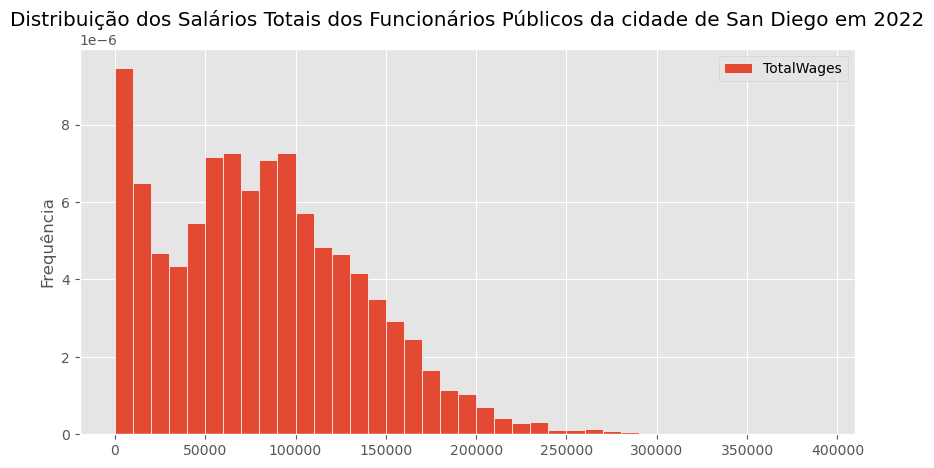

In [5]:
population.plot(kind='hist', bins=np.arange(0, 400000, 10000), density=True, ec='w', figsize=(10, 5),
                title='Distribui√ß√£o dos Sal√°rios Totais dos Funcion√°rios P√∫blicos da cidade de San Diego em 2022')
plt.ylabel('Frequ√™ncia');

### Sal√°rio mediano

- Podemos utilizar a fun√ß√£o `.median()` para calcular o sal√°rio mediano de todos os funcion√°rios p√∫blicos da cidade de San Diego.
- Note que, como temos a popula√ß√£o _inteira_ dispon√≠vel, essa mediana √© um **par√¢metro**, i.e. **n√£o-aleat√≥ria**.

In [6]:
population_median = population.get('TotalWages').median()
population_median

78136.0

### Na pr√°tica, por√©m...

- Na pr√°tica, o processo de entrevistar **toda** a popula√ß√£o (no caso mais de 12,000 funcion√°rios) √© caro e pode consumir muito tempo.
    - Al√©m disso, muitas vezes √© imposs√≠vel entrevistar todos os indiv√≠duos da popula√ß√£o.

- O que fazemos ent√£o √© aferir os sal√°rios com base em uma amostra aleat√≥ria (nesse exemplo tomamos $n = 500$).

### Revis√£o da terminologia

- O DataFrame completo de sal√°rios, i.e. `population.get(['TotalWages'])`, √© a nossa **popula√ß√£o**.

- N√≥s observamos uma **amostra** de tamanho $n = 500$ dessa popula√ß√£o.

- Queremos determinar a **mediana populacional** (que √© um _par√¢metro_), mas como n√£o temos acesso √† popula√ß√£o completa, utilizaremos a **mediana amostral** (que √© uma _estat√≠stica_) como uma **estimativa** desse par√¢metro.

- Nesse processo, esperamos que a mediana amostral seja pr√≥xima da mediana populacional.

### A mediana amostral

Vamos amostrar 500 funcion√°rios aleatoriamente. Para fazer isso, podemos utilizar o m√©todo `.sample`.

In [7]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

# Take a sample of size 500.
my_sample = population.sample(500)
my_sample

TotalWages
10301       27866
6913        71861
5163        91843
...           ...
3002       121209
3718       109709
2394       131409

[500 rows x 1 columns]

Nesse notebook, n√£o vamos mais modificar `my_sample`, ent√£o esse DataFrame vai sempre se referir √† essa amostra em particular.

In [8]:
# Compute the sample median.
sample_median = my_sample.get('TotalWages').median()
sample_median

76237.0

### O qu√£o "confiantes" estamos que essa √© uma boa estimativa?

- Nossa estimativa √© fun√ß√£o da amostra aleat√≥ria particular `my_sample`. Se t√≠vessemos coletado outra amostra, a estimativa poderia ter sido diferente.

- **Agora, o qu√£o diferente nossa estimativa poderia ter sido?** Nosssa _confian√ßa_ na estimativa depende fundamentalmente da resposta √† essa pergunta.

- The sample median is a random number. It comes from some distribution, which we don't know. 

- **Se** conhec√©ssmos a distribui√ß√£o verdadeira da mediana amostral (i.e. a _distribui√ß√£o amostral_), essa distribui√ß√£o nos ajudaria a responder essa pergunta.
    - Distribui√ß√µes mais "estreitas" (i.e. com baixa _variabilidade/dispers√£o_) $\Rightarrow$ nossa estimativa em geral n√£o teria sido t√£o diferente.
    - Distribui√ß√µes mais "largas" (i.e. com alta variabilidade/dispers√£o) $\Rightarrow$ nossa estimativa em geral teria sido bem diferente.

### Uma abordagem ineficiente

- Uma ideia natural aqui ent√£o seria: coletar repetidas amostras de tamanho $n = 500$ **da popula√ß√£o** e calcular as medianas amostrais de cada uma.
    - Foi examente isso o que fizemos na aula anterior, quando calculamos a distribui√ß√£o emp√≠rica das m√©dias amostrais dos atrasos de v√¥os (como aproxima√ß√£o para a distribui√ß√£o amostral).

In [9]:
sample_medians = np.array([])
for i in np.arange(1000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([81686.5, 79641. , 75592. , ..., 79350. , 78826.5, 78459.5])

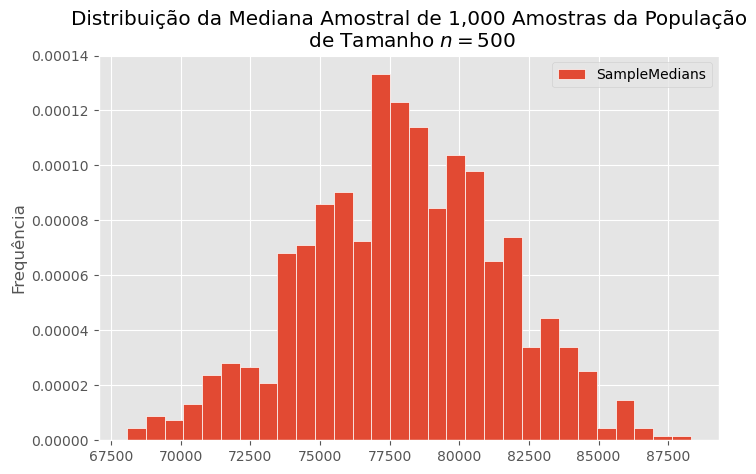

In [10]:
(bpd.DataFrame()
 .assign(SampleMedians=sample_medians)
 .plot(kind='hist', density=True,
       bins=30, ec='w', figsize=(8, 5),
       title='Distribui√ß√£o da Mediana Amostral de 1,000 Amostras da Popula√ß√£o\n de Tamanho $n = 500$')
)
plt.ylabel("Frequ√™ncia");

- Essa distribui√ß√£o emp√≠rica da mediana amostral √© uma aproxima√ß√£o para sua verdadeira distribui√ß√£o amostral.

### E porque essa abordagem √© ineficiente?

- Amostrar repetidas vezes da mesma popula√ß√£o muitas vezes √© infact√≠vel pelas mesmas raz√µes pelas quais n√£o trabalhamos com a popula√ß√£o desde o come√ßo!
    - Se pud√©ssemos fazer isso, porque n√£o simplesmente coletar mais dados (i.e. uma amostra maior)?

## Bootstrapping ü•æ

### Bootstrapping

- **Ideia principal**: Utilizar a amostra no lugar da popula√ß√£o.
    - Assumimos aqui que a amostra "se parece" com a popula√ß√£o.
    - Logo, _reamostrar da amostra_, de uma certa maneira, √© similar √† reamostrar da pr√≥pria popula√ß√£o!
    - Denominamos o conjunto de t√©cnicas que se baseiam em reamostragens a partir da amostra de **bootstrapping**.

### Com reposi√ß√£o ou sem reposi√ß√£o?

- Nosso objetivo quando realizamos um bootstrap √© gerar uma amostra do _mesmo tamanho_, por√©m com _algumas caracter√≠sticas_ diferentes da amostra original.

- Para ilustrar esse ponto, considere um exemplo simples onde vamos reamostrar repetidas vezes **sem reposi√ß√£o**, uma amostra original igual a [1, 2, 3].

In [13]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=False)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [2 1 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0


- Vamos agora repetir o mesmo experimento, mas dessa vez reamostrando **com reposi√ß√£o**:

In [14]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=True)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 3]     Median:  1.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 2]     Median:  1.0
Resample:  [2 1 3]     Median:  2.0
Resample:  [3 3 3]     Median:  3.0
Resample:  [1 1 1]     Median:  1.0
Resample:  [2 2 3]     Median:  2.0
Resample:  [2 3 2]     Median:  2.0
Resample:  [3 3 2]     Median:  3.0


- Conclu√≠mos com esse exemplo que:
    - Quando amostramos _sem reposi√ß√£o_, as novas amostras (amostras bootstrap) s√£o em um certo sentido "id√™nticas" √† amostra original ‚Äì muda se apenas a ordena√ß√£o dos indiv√≠duos.
        - Como consequ√™ncia, todas as suas caracter√≠sticas (isto √©, estat√≠sticas), s√£o _iguais_.
    - Por outro lado, quando amostramos _com reposi√ß√£o_, as amostras bootstrap em geral ter√£o caracter√≠sticas diferentes da amostra original.
        - As estat√≠sticas calculadas nas amostras bootstrap ser√£o em geral diferentes das calculadas na amostra original, o que nos permite aferir _variabilidade das estimativas_ entre as amostras e/ou construir uma distribui√ß√£o amostral para as estat√≠sticas de interesse.

- Dessa forma, quando realizamos um bootstrap, sempre reamostramos **com reposi√ß√£o**, para garantir que as nossas amostras bootstrap possam ser diferentes da nossa amostra original.
    - O bootstrap funciona ent√£o como um processo que "imita", em um certo sentido, o ato de coletar novas amostras.

### Bootstrap na amostra de sal√°rios

Conforme dito anteriormente, para realizar o bootstrap na nossa amostra basta gerar novas amostras **reamostrando com reposi√ß√£o da nossa amostra original, `my_sample`**.

In [15]:
# Note that the population DataFrame, population, doesn't appear anywhere here.
# This is all based on one sample, my_sample.

np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

n_resamples = 5000
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample WITH REPLACEMENT.
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median.
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians.
    boot_medians = np.append(boot_medians, median)

In [16]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

### _Distribui√ß√£o bootstrap_ da mediana amostral

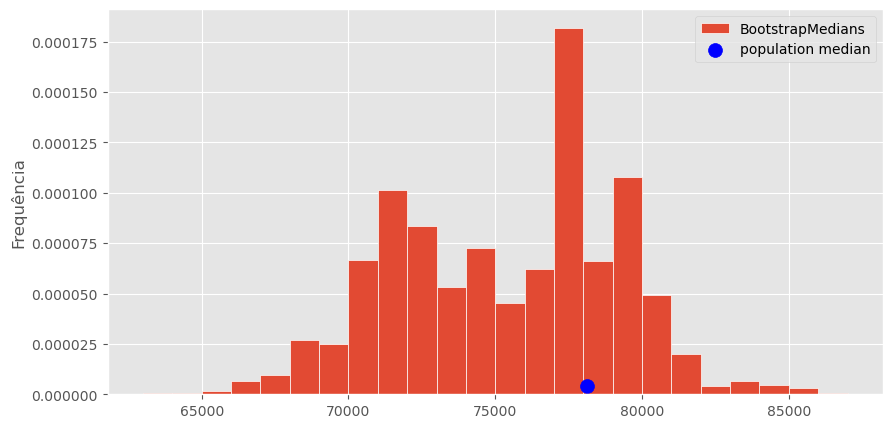

In [17]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend()
plt.ylabel("Frequ√™ncia");

Apenas para termos uma refer√™ncia do qu√£o boa √© nossa infer√™ncia, a mediana populacional √© reportada no histograma acima como um <span style="color:blue"><b>ponto azul</b></span>.

**Lembre por√©m que, na maior parte das situa√ß√µes, n√£o temos acesso √† essa informa√ß√£o!**

### Mas afinal, como o bootstrap nos ajuda a responder nossa pergunta original?

Lembre que, aqui, iniciamos apenas com a mediana amostral:

In [18]:
my_sample.get('TotalWages').median()

76237.0

Com base nessa estimativa, podemos dizer apenas que o sal√°rio mediano da popula√ß√£o √© aproximadamente \\$76,237, mas n√£o muito mais do que isso.

Em particular, n√£o podemos afirmar nada acerca da _variabilidade_ dessa estimativa, isto √©, o qu√£o _confiantes_ (ou incertos!) estamos sobre esse valor.

Ap√≥s realizarmos um bootstrap, por√©m, podemos gerar uma distribui√ß√£o emp√≠rica da mediana amostral:

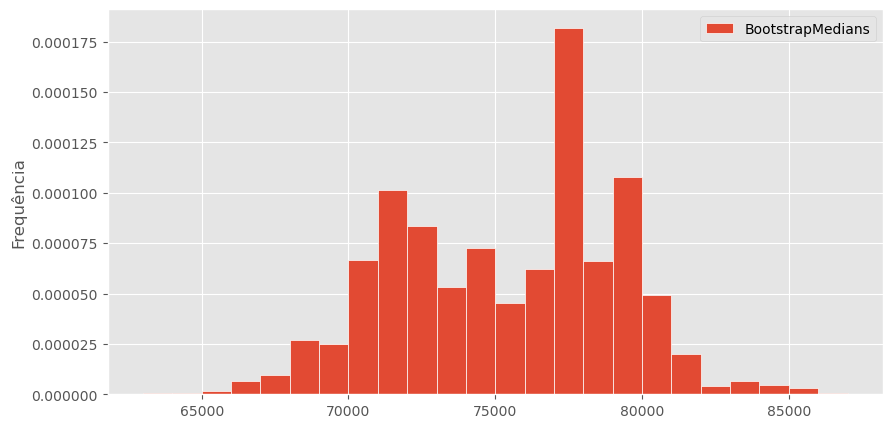

In [19]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
)
plt.legend()
plt.ylabel("Frequ√™ncia");

e essa distribui√ß√£o nos permite realizar afirma√ß√µes do tipo

> O sal√°rio mediano na popula√ß√£o est√° entre \\$68,000 e \\$82,000.

**Pergunta**: Poder√≠amos tamb√©m dizer que o sal√°rio mediano na popula√ß√£o est√° entre \\$70,000 e \\$80,000, ou entre \\$65,000 e \\$85,000. Qual desses dois intervalos voc√™ reportaria?

## Percentis

### Defini√ß√£o informal

> Seja $p$ um n√∫mero entre 0 e 100. O $p$-√©simo percentil de um conjunto de observa√ß√µes √© o n√∫mero que √© maior ou igual a $p\%$ de todos os valores do conjunto.

<center><img src="images/percentile2.jpg" width=600></center>

**Outro exemplo**: Se voc√™ est√° no percentil $80$ da altura de um certo conjunto de pessoas, isso significa que aproximadamente $80\%$ das pessoas desse conjunto s√£o mais baixas que voc√™, e que $20\%$ s√£o mais altas.

<center><img src="images/percentile.svg" width=400></center>

### Calculando os percentis

- O pacote `numpy` cont√©m uma fun√ß√£o para calcular percentis, `np.percentile(array, p)`, que retorna o `p`-√©simo percentil de `array`. 
- Por enquanto, n√£o entraremos em detalhes sobre como esse valor √© calculado ‚Äì nos concentraremos apenas em utilizar o resultado.
    - Retornaremos √† esse ponto mais adiante, mas apenas para uma breve reflex√£o: voc√™ acha que ordenar a amostra, calcular as frequ√™ncias correspondentes e encontrar o valor correspondente √† frequ√™ncia $p\%$ em geral √© suficiente?

In [20]:
np.percentile([4, 6, 9, 2, 7], 50)

6.0

In [21]:
np.percentile([2, 4, 6, 7, 9], 50)

6.0

## Intervalos de confian√ßa

Anteriormente, geramos uma distribui√ß√£o boostrap da mediana amostral:

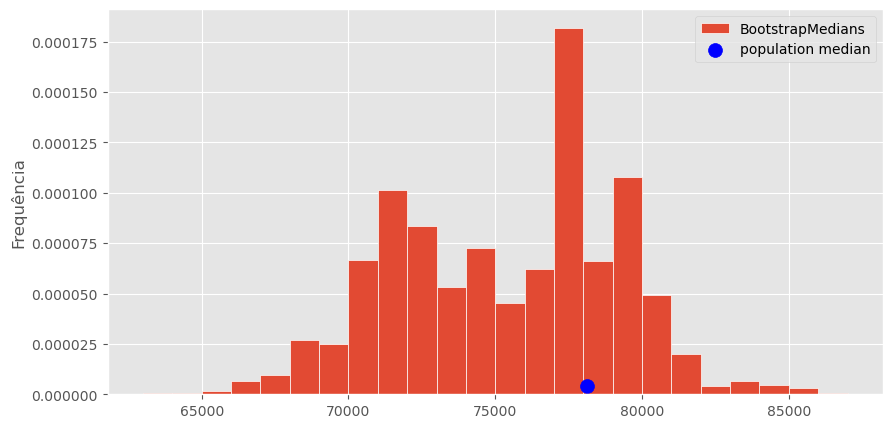

In [22]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend()
plt.ylabel("Frequ√™ncia");

Com base nessa distribui√ß√£o, o que podemos ent√£o afirmar em termos de percentis?

### Utilizando a distribui√ß√£o bootstrap da mediana amostral

- Nossa mediana amostral √© igual a \\$76,237.

- Conforme mencionamos anteriormente, acreditamos que a mediana populacional seja _pr√≥xima_ de \\$76,237, mas n√£o sabemos _qu√£o_ pr√≥xima.

- Como quantificar ent√£o a incerteza sobre essa estimativa?

- üí° **Ideia:** Encontrar um intervalo que contenha **a maior parte** (por exemplo, 95%) das medianas amostrais na distribui√ß√£o bootstrap. Intervalos desse tipo s√£o denominados de **intervalos de confian√ßa**.
    - Mais uma vez ressaltamos que aqui nosso principal objetivo √© entender e aprender como utilizar os conceitos introduzidos ‚Äì uma formaliza√ß√£o completa do conceito de intervalo de confian√ßa ser√° feita em outras disciplinas mais adiante. 

### Definindo um intervalo de confian√ßa [*]

- No exemplo acima, queremos encontrar um intervalo $[x,y]$ que contenha aproximadamente 95% da √°rea total da distribui√ß√£o bootstrap. Denominamos esse intervalo de **intervalo de 95% de confian√ßa** (IC95%).
    - Note que um intervalo de confian√ßa _n√£o √© √∫nico_ ‚Äì mais adiante veremos como calcular diferentes intervalos para um mesmo **n√≠vel de confian√ßa**.

- Uma maneira de encontrar esse intervalo √© encontrar dois pontos, $x$ e $y$, tais que:
    - A √°rea _√† esquerda_ de $x$ na distribui√ß√£o bootstrap seja aproximadamente 2.5%.
    - A √°rea _√† direita_ de $y$ na distribui√ß√£o bootstrap seja aproximadamente 2.5%.

- Pela defini√ß√£o de percentil dada acima, temos ent√£o que $x$ e $y$ s√£o os percentis **2.5** e **97.5**, respectivamente.
    - Usualmente, $x$ e $y$ s√£o respectivamente denominados **limite inferior** e **limite superior** do intervalo de confian√ßa.  

### Encontrando os limites do IC95% com np.percentile

In [23]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

In [24]:
# Left endpoint.
left = np.percentile(boot_medians, 2.5)
left

68469.0

In [25]:
# Right endpoint.
right = np.percentile(boot_medians, 97.5)
right

81253.5

In [26]:
# Therefore, our interval is:
[left, right]

[68469.0, 81253.5]

Utilizamos c√≥digos como esse acima o **tempo todo** em Ci√™ncia de Dados!

### Visualizando nosso IC95%
- Vamos agora plotar o intervalo que acabamos de calcular no histograma anterior.
- Lembre que, pela defini√ß√£o do IC95%, que 95% das medianas da distribui√ß√£o bootstrap est√£o contidas nesse intervalo.

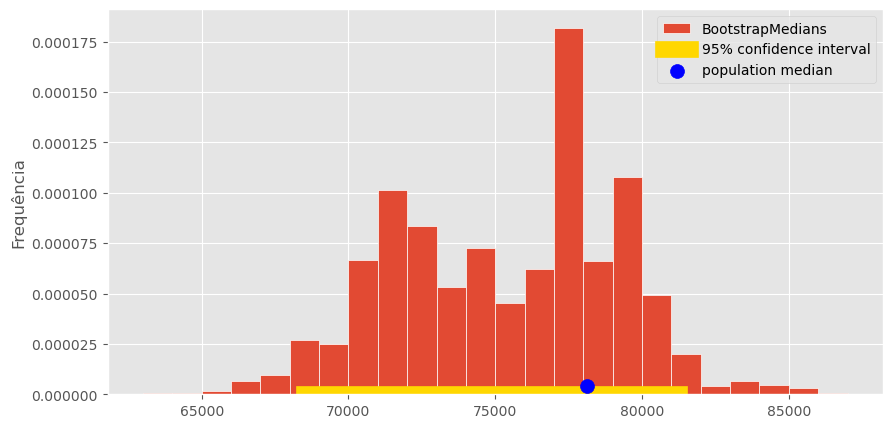

In [27]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5), zorder=1)
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval', zorder=2);
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median', zorder=3)
plt.legend()
plt.ylabel("Frequ√™ncia");

- Nesse exemplo, note que nosso IC95% (representado pela <span style="color:gold"><b>linha dourada</b></span>) cont√©m o verdadeiro valor do par√¢metro, isto √©, a mediana populacional (representada pelo <span style="color:blue"><b>ponto azul</b></span>).
    - Note que _isso nem sempre acontece_, pois a amostra original pode n√£o ser t√£o boa!
    - Na pr√°tica, al√©m de n√£o saber o qu√£o pr√≥xima a mediana amostral est√° da mediana populacional, em geral tamb√©m n√£o saberemos o qu√£o boa a nossa amostra original realmente √©.
    - Discutiremos na pr√≥xima aula algumas maneiras de contornar esse problema.

- Finalmente, note pelo histograma acima que nesse exemplo a distribui√ß√£o bootstrap n√£o est√° centrada na _mediana populacional_ (de \\$78,136), mas sim na _mediana amostral_ (\\$76,237).

### Teste R√°pido ‚úÖ

Suponha que tenhamos calculado o seguinte IC95%:

In [28]:
print('Interval:', [left, right])
print('Width:', right - left)

Interval: [68469.0, 81253.5]
Width: 12784.5


onde `Width` acima representa a **largura** do IC, i.e. se $IC95\% = [y, x]$, sua largura √© igual a $y - x$. 

Agora, se ao inv√©s de 95\% de confian√ßa tiv√©ssemos calculado um intervalo de 80% de confian√ßa, isto √©, um IC80\%, voc√™ acha que esse intervalo seria _mais largo_ ou _mais estreito_ do que o IC95%?

- A.  Mais largo
- B.  Mais estreito
- C.  √â imposs√≠vel dizer

## "Armadilhas" do bootstrap

### Regras de bolso

- Bootstrap √© uma t√©cnica bem poderosa! N√≥s apenas precisamos coletar uma √∫nica amostra para obter uma distribui√ß√£o aproximada para a mediana amostral.

- Por√©m, essa t√©cnica tem suas limita√ß√µes:
    - O bootstrap n√£o √© muito bom para estat√≠sticas mais "sens√≠veis" a valores extremos (como por exemplo o m√°ximo, ou o m√≠nimo).
         - Essa t√©cnica funciona melhor para estat√≠sticas que s√£o mais "robustas" (a _outliers_).
    - O boostrap fornece bons resultados apenas se a amostra √© "suficientemente pr√≥xima" da popula√ß√£o.
        - Se nossa amostra original **n√£o for representativa da popula√ß√£o**, as amostras bootstrap tamb√©m n√£o ser√£o representativas da popula√ß√£o.

### Exemplo: Estimando o m√°ximo de uma quantidade populacional

- Suponha que, ao inv√©s da mediana, estejamos agora interessados no _m√°ximo_ dos sal√°rios de todos os funcion√°rios p√∫blicos da cidade de San Diego (nossa popula√ß√£o).
- Nossa amostra coletada continua a mesma que t√≠nhamos anteriormente, `my_sample`.
- Nossa estimativa ser√° igual ao m√°ximo dos sal√°rios amostrais (i.e. o maior sal√°rio contido na amostra). Esse m√°ximo √© uma estat√≠stica.

- Para obter uma distribui√ß√£o emp√≠rica do m√°ximo, fazemos ent√£o o seguinte bootstrap:

In [1]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):
    resample = my_sample.sample(500, replace=True)
    boot_max = resample.get('TotalWages').max()
    boot_maxes = np.append(boot_maxes, boot_max)

NameError: name 'np' is not defined

In [ ]:
boot_maxes

### Visualizando os resultados

Como aqui temos acesso √† popula√ß√£o, podemos encontrar o m√°ximo populacional direto (sem bootstrap), apenas para compara√ß√£o.

In [ ]:
population_max = population.get('TotalWages').max()
population_max

Ent√£o, ser√° que o m√°ximo populacional se encontra na parte com "mais massa" da distribui√ß√£o bootstrap?

In [ ]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='blue', s=100, label='population max')
plt.legend();

Na verdade n√£o! A distribui√ß√£o bootstrap (e os ICs que podemos construir atrav√©s dela) n√£o captura muito bem o m√°ximo populacional, representado no histograma acima pelo <span style="color:blue"><b>ponto azul</b></span> igual a \$384,909.

> E porque n√£o?! ü§î

In [ ]:
my_sample.get('TotalWages').max()

- O maior valor na nossa amostra original √© de \\$347,755. Logo, o maior valor na nossa amostra bootstrap ser√° no m√°ximo igual a \\$347,755.

- Em geral, o bootstrap funciona melhor para medidas de tend√™ncia central ou dispers√£o (como a m√©dia, mediana, desvio padr√£o, etc.) do que para medidas que s√£o mais sens√≠veis a outliers, como os extremos (m√°ximo e m√≠nimo).

### Para refletir [*]

Na aula anterior, aprendemos a fazer afirmativas do tipo

> Acreditamos que a mediana populacional est√° "pr√≥xima" da nossa mediana amostral, \\$76,237.

Nessa aula, aprendemos a fazer afirmativas do tipo

> Podemos dizer, com "95% de confian√ßa", que a mediana populacional est√° entre \\$68,469 e \\$81,253.50.

## Resumo [*]

- Com base em uma amostra, queremos inferir sobre um par√¢metro populacional. Por√©m, como podemos calcular apenas uma estimativa com essa amostra, em geral n√£o sabemos o qu√£o _precisa_ √© essa estimativa.
    - Para termos uma ideia do qu√£o vari√°vel √© nossa estimativa, idealmente coletar√≠amos mais amostras e calcular√≠amos nossa estat√≠stica em cada uma dessas amostras. Por√©m, na pr√°tica, amostrar em geral √© caro, e logo usualmente temos dispon√≠vel **apenas uma amostra**.
- **Ideia principal**: Sob certas condi√ß√µes, a amostra √© distribu√≠da de maneira bem similar √† popula√ß√£o da qual a amostra foi coletada. Dessa forma, podemos tratar a distribui√ß√£o emp√≠rica da amostra como se fosse a distribui√ß√£o populacional e produzir novas amostras **reamostrando** da amostra original.
    - Cada nova amostra produzida dessa forma gera nos permite calcular uma nova estimativa. Com base em um conjunto dessas estimativas, podemos ent√£o ter uma no√ß√£o da precis√£o/variabilidade da nossa estimativa original.
- O **Bootstrap** nos fornece uma maneira de gerarmos uma distribui√ß√£o emp√≠rica de uma estat√≠stica, utilizando apenas uma √∫nica amostra original. Com base nessa **distribui√ß√£o bootstrap**, podemos criar intervalos de $c$% confian√ßa identificando os valores cujo intervalo contenha $c$% da distribui√ß√£o entre si.
    - Podemos assim **quantificar a incerteza** sobre nossas estimativas, e fazer afirma√ß√µes do tipo "a m√©dia populacional est√° entre \\$68,469 e \\$81,253.50" ao inv√©s de afirmar apenas que "a m√©dia populacional √© aproximadamente \\$76,237".



- O bootstrap funciona bem para estat√≠sticas que n√£o s√£o t√£o sens√≠veis √† pequenas varia√ß√µes na amostra (tais como a m√©dia e a mediana, mas n√£o para m√°ximos e m√≠nimos). [*]